**Introduction to Timeseries**

*   Objective - predicting future Bitcoin prices using historical data
*   Overview



**Prerequisites**



*   Basic Knowledge of PyTorch
*   Understanding Time Series Data - Time series data involves sequences of data points indexed in time order.



**Imports**

In [1]:
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Data Acquisition and Preprocessing**

In [3]:
url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30'

params = {
    'vs_currency': 'usd',  # Specify the currency you want to get prices in
    'days': 'max',  # Get maximum available data
    'interval': 'daily'}


response = requests.get(url)
data = response.json()

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Convert timestamps to numeric values
df['timestamp'] = df['timestamp'].astype('int64') // 10**9

# Normalize the timestamp and price
scaler = MinMaxScaler(feature_range=(0, 1))
df[['normalized_timestamp', 'normalized_price']] = scaler.fit_transform(df[['timestamp', 'price']])

df.head()

,timestamp,price,normalized_timestamp,normalized_price
0,1737943426,101234.889569,0.000000,0.756335
1,1737947012,100923.408947,0.001383,0.740041
2,1737950440,101284.674599,0.002706,0.758939
3,1737954237,100383.213489,0.004171,0.711783
4,1737957736,100385.402841,0.005521,0.711897


**Exploratory Data Analysis (EDA)**




Basic Statistics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             721 non-null    int64  
 1   price                 721 non-null    float64
 2   normalized_timestamp  721 non-null    float64
 3   normalized_price      721 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 22.7 KB


In [5]:
df.describe()

,timestamp,price,normalized_timestamp,normalized_price
count,7.210000e+02,721.000000,721.000000,721.000000
mean,1.739239e+09,97809.597197,0.499991,0.577154
std,7.498277e+05,3189.834881,0.289275,0.166863
min,1.737943e+09,86776.454675,0.000000,0.000000
25%,1.738591e+09,96139.623565,0.249995,0.489796
50%,1.739239e+09,97183.012360,0.499987,0.544377
75%,1.739887e+09,98941.172578,0.749997,0.636348
max,1.740536e+09,105892.906823,1.000000,1.000000


Data Visualization

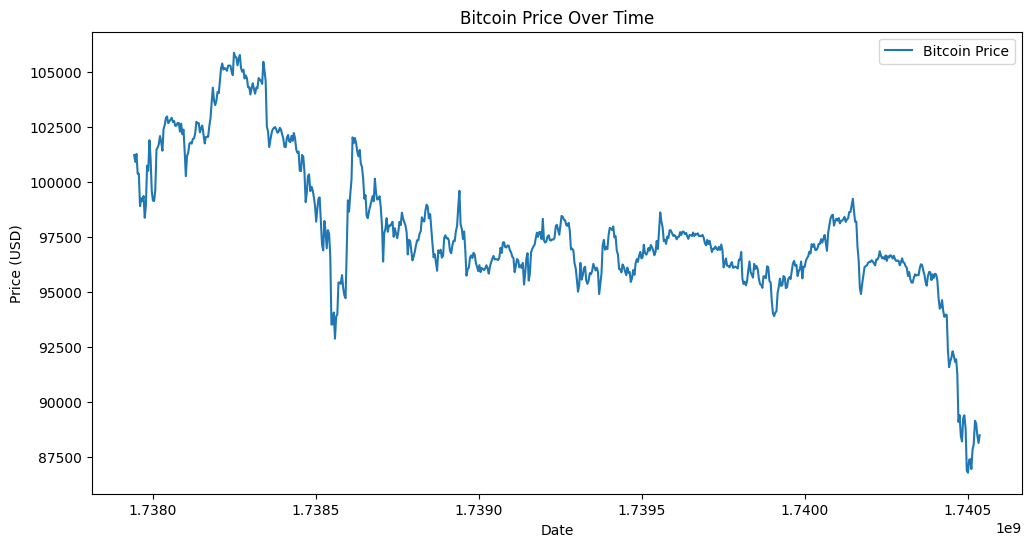

In [6]:
import matplotlib.pyplot as plt

# Plot the Bitcoin prices
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['price'], label='Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price Over Time')
plt.legend()
plt.show()


**Create Sequences**

The create_sequences function is essential for preparing time series data for training a model. In time series forecasting, models need to learn patterns and trends over sequences of time steps.

In [7]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        label = data[i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

**Creating Training and Test Sets**

Since time series data is ordered chronologically, you'll need to define a point in time where you'll split your data. Typically, the data before this point will be used for training, and the data after this point will be used for testing. It's crucial to keep the temporal order intact. Unlike other types of data, shuffling your time series data can lead to misleading results.

In [8]:
# start and end dates
start_date = df.iloc[0]['timestamp']
end_date = df.iloc[-1]['timestamp']

split_index = int(len(df) * 0.7)

train_data = df.iloc[:split_index]
val_data = df.iloc[split_index:]

In [9]:
print("Training set:")
print(train_data[:5])
print("\nValidation set:")
print(val_data[:5])

Training set:
    timestamp          price  normalized_timestamp  normalized_price
0  1737943426  101234.889569              0.000000          0.756335
1  1737947012  100923.408947              0.001383          0.740041
2  1737950440  101284.674599              0.002706          0.758939
3  1737954237  100383.213489              0.004171          0.711783
4  1737957736  100385.402841              0.005521          0.711897

Validation set:
      timestamp         price  normalized_timestamp  normalized_price
504  1739757717  96529.148633              0.699932          0.510173
505  1739761253  96203.282951              0.701296          0.493126
506  1739765209  96185.610605              0.702822          0.492202
507  1739768641  96124.054814              0.704146          0.488982
508  1739772227  96258.468351              0.705530          0.496013


In [10]:
# Define the sequence length
sequence_length = 30

# Create sequences and labels for training data
train_sequences, train_labels = create_sequences(train_data[['normalized_timestamp', 'normalized_price']].values, sequence_length)

# Create sequences and labels for validation data
val_sequences, val_labels = create_sequences(val_data[['normalized_timestamp', 'normalized_price']].values, sequence_length)



In [11]:
train_sequences.shape, train_labels.shape

((474, 30, 2), (474, 2))

In [12]:
len(train_data), len(val_data)

(504, 217)

In [13]:
print(type(train_data))

<class 'pandas.core.frame.DataFrame'>


In [14]:
# # Calculate additional features
# prices['7_day_avg'] = prices['price'].rolling(window=7).mean()
# prices['30_day_avg'] = prices['price'].rolling(window=30).mean()
# prices['daily_return'] = prices['price'].pct_change()
# prices['volatility'] = prices['price'].rolling(window=30).std()

# # Drop NaN values created by rolling calculations
# prices.dropna(inplace=True)

# # Calculate the correlation matrix
# correlation_matrix = prices[['price', '7_day_avg', '30_day_avg', 'daily_return', 'volatility']].corr()

# # Display the correlation matrix
# print(correlation_matrix)

# # Plot the heatmap of the correlation matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix')

In [15]:
# Custom dataset turning pandas df into datasets


class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_tensor = torch.tensor(self.sequences[idx][:, 0], dtype=torch.float32).unsqueeze(-1)  # Normalized timestamps
        label_tensor = torch.tensor(self.labels[idx][1], dtype=torch.float32)  # Normalized prices
        return sequence_tensor, label_tensor


# Create dataset instances
train_dataset = TimeSeriesDataset(train_sequences, train_labels)
val_dataset = TimeSeriesDataset(val_sequences, val_labels)



# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
len(train_loader), len(val_loader)

(30, 12)

In [17]:
for batch_idx, (sequences, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx+1}")
    print(sequences.shape, labels.shape)

    break  # Just to show the first batch for example purposes

Batch 1
torch.Size([16, 30, 1]) torch.Size([16])


**LSTM (Long Short-Term Memory)**

LSTM networks belong to the family of recurrent neural networks (RNNs) and are particularly adept at handling time series data. They excel at capturing long-term dependencies and recognizing patterns over time.

In [22]:
# Simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out


# Hyperparameters
input_size = 1
hidden_size = 150
num_layers = 10
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

**Training loop**

In [23]:
num_epochs = 100
learning_rate = 0.0001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [24]:
for epoch in range(num_epochs):
  model.train()
  for i, (sequences, labels) in enumerate(train_loader):
    sequences = sequences.to(device)
    labels = labels.to(device).float()

    optimizer.zero_grad()
    # Forward pass
    outputs = model(sequences)
    outputs = outputs.squeeze()
    # print(outputs[0])
    # print(labels[0])
    loss = loss_fn(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # Print training progress
    if (epoch + 1) % 5 == 0 and i ==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')


  scheduler.step()
  # Prepare the data for plotting
  model.eval()
  val_loss = 0.0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for sequences, labels in val_loader:
          sequences = sequences.to(device)
          labels = labels.to(device).float()

          outputs = model(sequences)
          outputs = outputs.squeeze()

          # for plotting
          all_predictions.extend(outputs.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

          loss = loss_fn(outputs, labels)
          val_loss += loss.item()
      val_loss /= len(val_loader)

      if (epoch + 1) % 5 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}')



Epoch [5/100], Train Loss: 0.0919
Epoch [5/100], Val Loss: 0.0324
Epoch [10/100], Train Loss: 0.0731
Epoch [10/100], Val Loss: 0.0366
Epoch [15/100], Train Loss: 0.0652
Epoch [15/100], Val Loss: 0.0399
Epoch [20/100], Train Loss: 0.0601
Epoch [20/100], Val Loss: 0.0424
Epoch [25/100], Train Loss: 0.0565
Epoch [25/100], Val Loss: 0.0444
Epoch [30/100], Train Loss: 0.0538
Epoch [30/100], Val Loss: 0.0460
Epoch [35/100], Train Loss: 0.0516
Epoch [35/100], Val Loss: 0.0470
Epoch [40/100], Train Loss: 0.0027
Epoch [40/100], Val Loss: 0.0295
Epoch [45/100], Train Loss: 0.0060
Epoch [45/100], Val Loss: 0.0306
Epoch [50/100], Train Loss: 0.0100
Epoch [50/100], Val Loss: 0.0326
Epoch [55/100], Train Loss: 0.0035
Epoch [55/100], Val Loss: 0.0315
Epoch [60/100], Train Loss: 0.0073
Epoch [60/100], Val Loss: 0.0321
Epoch [65/100], Train Loss: 0.0058
Epoch [65/100], Val Loss: 0.0322
Epoch [70/100], Train Loss: 0.0064
Epoch [70/100], Val Loss: 0.0322
Epoch [75/100], Train Loss: 0.0062
Epoch [75/100],

**Model Evaluation**

*   Metrics - Discuss metrics for evaluating time series forecasting models
*   Visualizatio - Plot the predicted vs. actual prices to visually assess the  
    model's performance.



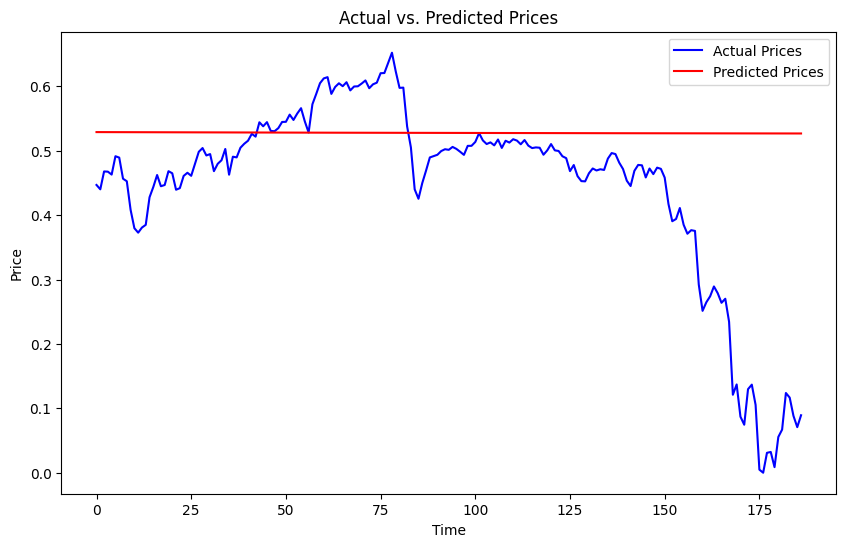

In [25]:
# Convert to numpy arrays for plotting
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(all_labels, label='Actual Prices', color='b')
plt.plot(all_predictions, label='Predicted Prices', color='r')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**Making Predictions**

*   Forecasting
*   Visualization:



In [35]:
# Assuming historical_data is taken from the end of your validation set
historical_data = val_loader.dataset[-1][0].squeeze().cpu().numpy()

num_forecast_steps = 30
forecasted_values = []

with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        # Update historical data with the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value  # Assign the new value

